In [41]:
import pandas as pd, time, psycopg2, warnings, os, matplotlib.pyplot as plt, seaborn as sns, re, numpy as np, nltk, unicodedata
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import spacy


#seting the columns views to full
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)
#disable warnings
warnings.filterwarnings('ignore')
os.chdir('C:/Users/a0056407/Desktop/TMFINAL20JAN2023/')

In [42]:
conn = psycopg2.connect(user="postgres", password="postgres",
                                  host="127.0.0.1", port="5432", database="mike")
cursor = conn.cursor()
#sql_cmd1 = "select id, disease_description from cleaned_reports"
sql_cmd1 = "select id, disease_description from verbal_autopsy"
cursor.execute(sql_cmd1)
#cursor.execute(sql_cmd2)
dfA = pd.read_sql(sql_cmd1, conn)
#df2 = pd.read_sql(sql_cmd2, conn)
#closing the connection
cursor.close()
conn.close()
dfA.head()

,id,disease_description
0,100012,Deceased started to ill while at working place...
1,100018,The deceased developed blisters under the righ...
2,100077,He was having a painful penis. His body was h...
3,100078,At first the deceased was complaining about br...
4,100094,He started by coughing and have difficulty in ...


In [43]:
dfA.tail()

,id,disease_description
16077,651348,None
16078,652073,None
16079,653819,None
16080,653821,None
16081,654065,None


In [44]:
#remove nan
dfA = dfA.dropna(subset=['disease_description'])
#convert to string
dfA['disease_description'] = dfA['disease_description'].astype(str)
# Remove punctuation
dfA['disease_description'] = dfA['disease_description'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
dfA['disease_description'] = dfA['disease_description'].map(lambda x: x.lower())

# Print out the first rows of papers
dfA['disease_description'].head()

0    deceased started to ill while at working place...
1    the deceased developed blisters under the righ...
2    he was having  a painful penis his body was ho...
3    at first the deceased was complaining about br...
4    he started by coughing and have difficulty in ...
Name: disease_description, dtype: object

In [45]:
dfA['disease_description'].tail()

16027    she started by coughing fever and have diarrho...
16031    the deceased started by coughing where she was...
16045    she started by complaining with headache and a...
16055    the deceased started by having painful abdomen...
16061                    she was found dead in the morning
Name: disease_description, dtype: object

In [46]:
#common word removal
freq = pd.Series(' '.join(dfA['disease_description']).split()).value_counts()[:25]
freq

was          115025
and           73320
the           65576
he            64383
she           62965
to            59468
hospital      23693
taken         23075
given         21660
treatment     20479
after         20337
a             19984
but           17881
at            16255
where         15793
started       15471
her           13195
in            12883
for           12425
of            12044
died          11528
his           10726
body          10364
not            9850
on             9829
dtype: int64

In [47]:
#removing irrelevant common words
freq = list(freq.index)
dfA['disease_description'] = dfA['disease_description'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
dfA['disease_description'].head()

0    deceased ill while working place came home whi...
1    deceased developed blisters under right breast...
2    having painful penis hot sometimes it cold hav...
3    first deceased complaining about breast pain w...
4    by coughing have difficulty breathing bhubezi ...
Name: disease_description, dtype: object

In [48]:
#rare word removal
freq = pd.Series(' '.join(dfA['disease_description']).split()).value_counts()[-5000:]
freq

germistonhe                     1
alonethey                       1
abormal                         1
sonfew                          1
stoppedstill                    1
remebering                      1
onesand                         1
canceragain                     1
whie                            1
cghanged                        1
onewhile                        1
ribs(both                       1
sides)and                       1
pussagain                       1
comaplaining                    1
collogue                        1
chillsnothing                   1
hotby                           1
hallucingating                  1
chec-ups                        1
similarly                       1
(similarly                      1
baragwaneth)                    1
itchythough                     1
cloth(wearing                   1
sleeves)few                     1
(ndaphwa)traditional            1
(outside)after                  1
toafter                         1
chopped       

In [49]:
#removing irrelevant rare words adding noise to data
freq = list(freq.index)
dfA['disease_description'] = dfA['disease_description'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
dfA['disease_description'].head()

0    deceased ill while working place came home whi...
1    deceased developed blisters under right breast...
2    having painful penis hot sometimes it cold hav...
3    first deceased complaining about breast pain w...
4    by coughing have difficulty breathing bhubezi ...
Name: disease_description, dtype: object

In [50]:
#spelling correction
from textblob import TextBlob
dfA['disease_description'][:5].apply(lambda x: str(TextBlob(x).correct()))

0    deceased ill while working place came home whi...
1    deceased developed blisters under right breast...
2    having painful penis hot sometimes it cold hav...
3    first deceased complaining about breast pain w...
4    by coughing have difficulty breathing bhubezi ...
Name: disease_description, dtype: object

In [51]:
print('Most common words before stop words removal')
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(dfA['disease_description'], 20)
for word, freq in common_words:
    print(word, freq)

Most common words before stop words removal
admitted 9438
better 9207
it 9019
deceased 8832
that 8736
with 8675
had 8209
then 8025
home 7953
days 7942
also 7694
by 7482
from 6951
clinic 6860
they 6512
breathing 6348
unable 6289
traditional 6178
when 6125
doctor 6109


In [52]:
dfA['disease_description'] = dfA['disease_description'].str.replace(r'traditiaonal', 'traditional') 
dfA['disease_description'] = dfA['disease_description'].str.replace(r'diarrhoea', 'diarrhea') 
dfA['disease_description'] = dfA['disease_description'].str.replace(r'diarrheoa', 'diarrhea')
dfA['disease_description'] = dfA['disease_description'].str.replace(r'diarrhorea', 'diarrhea')
dfA['disease_description'] = dfA['disease_description'].str.replace(r'diariheoa', 'diarrhea')
dfA['disease_description'] = dfA['disease_description'].str.replace(r'diatthoea', 'diarrhea')
dfA['disease_description'] = dfA['disease_description'].str.replace(r'diarrhoe', 'diarrhea')
dfA['disease_description'] = dfA['disease_description'].str.replace(r'diarrho', 'diarrhea')
dfA['disease_description'] = dfA['disease_description'].str.replace(r'x-ray', 'xray')
dfA['disease_description'] = dfA['disease_description'].str.replace(r'vomitting', 'vomit')
dfA['disease_description'] = dfA['disease_description'].str.replace(r'vomiting', 'vomit')
dfA['disease_description'] = dfA['disease_description'].str.replace(r'vomitte', 'vomit')
#dfA['disease_description'] = dfA['disease_description'].str.replace(r'didnt', '')

In [53]:
regexp = RegexpTokenizer('\w+')
dfA['disease_description_tokens'] = dfA['disease_description'].apply(regexp.tokenize)
dfA.head()

,id,disease_description,disease_description_tokens
0,100012,deceased ill while working place came home whi...,"[deceased, ill, while, working, place, came, h..."
1,100018,deceased developed blisters under right breast...,"[deceased, developed, blisters, under, right, ..."
2,100077,having painful penis hot sometimes it cold hav...,"[having, painful, penis, hot, sometimes, it, c..."
3,100078,first deceased complaining about breast pain w...,"[first, deceased, complaining, about, breast, ..."
4,100094,by coughing have difficulty breathing bhubezi ...,"[by, coughing, have, difficulty, breathing, bh..."


In [54]:
# Make a list of english stopwords
stopwords = nltk.corpus.stopwords.words("english")
# Extend the list with your own custom stopwords
my_stopwords = ['traditional','spot','way','hit','scene','injure','fall','operation','matikwane','pa','feeling',
                   'nose','zcc','tea','bear', 'hand','froth','minute','head','ache','bone','ear','eye', 'didnt',
                   'groan','armpit', 'result','foot','big','nurse','severe','face','colour','receive',
                   'cry','pas','suffer','treat','breath','begin','continue','symptom','family',
                   'waterdrip','give','injection','eat', 'face','stop','stay','try','house','family','wife',
                   'year','eat','period','cause','happen', 'bhubezi','eat','take','another','leg','stayed',
                   'become','mother','talk','even','drinking','talking','later','whole','took','used','help',
                   'breathing','days','didnt', 'daignosed','consulted','found','one','also','times','unable', 
                   'tshepo','thembeka','still','week','seem','active','pitting','well','since','sleep','past',
                   'ten', 'weather','fatten','slept','bathed','without','saw','continue','healthy','year','old',
                   'could','confirmed','grandmother','unkown','following','bottle','duck','growing', 'middle',
                   'knee','slightly','shrinked','impossible','valboven','sure','tuesday','arrive','found', 
                   'tintswalo','lost','nurse','coccyx','vein','baby','boy','girl','gave','birth', 'child',
                   'level','showed','released','visit','checkup','collecting','cnnot','release','woke','since',
                   'twin','morning','bathed','give','swallow','could','much','information','drink', 'uncooked',
                   'straight','clenched','till','appear','small','made','found','medication','one','found','dead',
                   'pa','loss','appetite','thin','abnormal','sugar','appeared','suffering', 'felt','always','showing',
                   'told','longer','respondent','eating','food','painful','coughing','discharged','stopped','baby',
                   'still','got','eating','dont','know','tested','something', 'moving','test','result','sign','2','5',
                   'week','x','ray','justicia','inserted','tintswalo','week','drain','water','smelling','bad','drips',
                   'getting','open','mouth','anything','noisy', 'injection','serious','legs','hands','difficulty',
                   'x ray','diagnosed','doctors','said','inside','damaged','tube','experienced','walk','hed',
                   'months','first','complaining','left','side', 'cold','chilling','comes','became','night',
                   'illness','checks','tablets','worse','sometimes','difficulties','tablet','month','every',
                   'week','rob','diagnosis','via','shop','ferreira', 'bought','lot','gradually','loosing','right',
                   'xray','continued','recurrent','skip','defacating','hard','black','check','healed','get','healer',
                   'throughout','beginning','lot','come', 'healed','healer','condition','unchanged','tinswalo',
                   'oxygen','supplier','finally','third','death','visited','get','medicine','contnued','using',
                   'condition','three','remains','death', 'thing','like','lower','belfast','start','ill','difficult',
                   'collect','letter','referred','tb','improvement','developed','examined','complained','afterwards',
                   'working','place','came', 'experiencing','started','tel','telephone','fax','given','went','examine',
                   'start','work','place','came','vist','home','back','day','say','wrong','better','died','deceased',
                   'week', 'time','several','start','problem','never','stop','drip','done','drip','two','day',
                   'changed','doctor','taken','weeks','private','admitted','hospital','treatment','nothing','change',
                   'matikwana','health','centre','clinic','passed','away','agincourt','four','tell','next','hour',
                   'examination','gauteng','cry','friend','ambulance','use','properly','walking','able','suffered','mapulaneng']
stopwords.extend(my_stopwords)
stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [55]:
# Remove stopwords
dfA['disease_description_tokens'] = dfA['disease_description_tokens'].apply(lambda x: [item for item in x if item not in stopwords])
dfA.head()

,id,disease_description,disease_description_tokens
0,100012,deceased ill while working place came home whi...,"[cough, chest, pain, tiredness, blood, vision,..."
1,100018,deceased developed blisters under right breast...,"[blisters, breast, blisters, blisters, cough, ..."
2,100077,having painful penis hot sometimes it cold hav...,"[penis, hot, passing, urine, penis]"
3,100078,first deceased complaining about breast pain w...,"[breast, pain, swollen, hot, pain, stiff, weak..."
4,100094,by coughing have difficulty breathing bhubezi ...,[organs]


In [56]:
dfA['disease_description'] = dfA['disease_description_tokens'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))
dfA.head()

,id,disease_description,disease_description_tokens
0,100012,cough chest pain tiredness blood vision stomac...,"[cough, chest, pain, tiredness, blood, vision,..."
1,100018,blisters breast blisters blisters cough weight...,"[blisters, breast, blisters, blisters, cough, ..."
2,100077,penis hot passing urine penis,"[penis, hot, passing, urine, penis]"
3,100078,breast pain swollen hot pain stiff weak stiff ...,"[breast, pain, swollen, hot, pain, stiff, weak..."
4,100094,organs,[organs]


In [57]:
wordnet_lem = WordNetLemmatizer()

dfA['disease_description'] = dfA['disease_description'].apply(wordnet_lem.lemmatize)
dfA.head()

,id,disease_description,disease_description_tokens
0,100012,cough chest pain tiredness blood vision stomac...,"[cough, chest, pain, tiredness, blood, vision,..."
1,100018,blisters breast blisters blisters cough weight...,"[blisters, breast, blisters, blisters, cough, ..."
2,100077,penis hot passing urine penis,"[penis, hot, passing, urine, penis]"
3,100078,breast pain swollen hot pain stiff weak stiff ...,"[breast, pain, swollen, hot, pain, stiff, weak..."
4,100094,organ,[organs]


In [58]:
def basic_clean(text):
  """
  A simple function to clean up the data. All the words that
  are not designated as a stop word is then lemmatized after
  encoding and basic regex parsing are performed.
  """
  wnl = nltk.stem.WordNetLemmatizer()
  updated_stopwords = nltk.corpus.stopwords.words('english')
  text = (unicodedata.normalize('NFKD', text)
    .encode('ascii', 'ignore')
    .decode('utf-8', 'ignore')
    .lower())
  words = re.sub(r'[^\w\s]', '', text).split()
  return [wnl.lemmatize(word) for word in words if word not in updated_stopwords]

dfA['disease_description'] = dfA['disease_description'].apply(basic_clean)
dfA['disease_description'] = dfA['disease_description'].apply(lambda x: ' '.join([item for item in x if len(item) > 2]))

dfA.head()

,id,disease_description,disease_description_tokens
0,100012,cough chest pain tiredness blood vision stomac...,"[cough, chest, pain, tiredness, blood, vision,..."
1,100018,blister breast blister blister cough weight he...,"[blisters, breast, blisters, blisters, cough, ..."
2,100077,penis hot passing urine penis,"[penis, hot, passing, urine, penis]"
3,100078,breast pain swollen hot pain stiff weak stiff ...,"[breast, pain, swollen, hot, pain, stiff, weak..."
4,100094,organ,[organs]


In [59]:
dfA.head()

,id,disease_description,disease_description_tokens
0,100012,cough chest pain tiredness blood vision stomac...,"[cough, chest, pain, tiredness, blood, vision,..."
1,100018,blister breast blister blister cough weight he...,"[blisters, breast, blisters, blisters, cough, ..."
2,100077,penis hot passing urine penis,"[penis, hot, passing, urine, penis]"
3,100078,breast pain swollen hot pain stiff weak stiff ...,"[breast, pain, swollen, hot, pain, stiff, weak..."
4,100094,organ,[organs]


In [60]:
dfA.to_excel(r'C:\Users\a0056407\Desktop\TMFINAL20JAN2023\processed.xlsx', index=False)

In [61]:
dfA.to_excel('new_excel.xlsx', sheet_name='new_sheet_name')

In [62]:
words = basic_clean(''.join(str(dfA['disease_description'].tolist())))

top_20_unigrams = (pd.Series(nltk.ngrams(words, 1)).value_counts())[:20]
top_20_unigrams

(pain,)         7429
(diarrhea,)     6342
(swollen,)      5916
(vomit,)        5468
(hot,)          5266
(cough,)        3795
(weak,)         3734
(blood,)        3610
(stomach,)      3498
(chest,)        3185
(headache,)     2948
(weight,)       1914
(stool,)        1566
(sweating,)     1360
(rash,)         1236
(energy,)       1203
(sore,)         1177
(low,)          1149
(wound,)        1140
(urinating,)    1061
dtype: int64

In [63]:
top_20_bigrams = (pd.Series(nltk.ngrams(words, 2)).value_counts())[:20]
top_20_bigrams

(chest, pain)           1944
(low, energy)            870
(diarrhea, vomit)        838
(stomach, pain)          640
(vomit, diarrhea)        592
(blood, pressure)        479
(stomach, swollen)       462
(high, blood)            456
(diarrhea, diarrhea)     449
(swollen, stomach)       441
(mental, confusion)      435
(hot, sweating)          391
(pa, stool)              388
(passing, stool)         352
(hiv, positive)          311
(vomit, vomit)           305
(cough, chest)           298
(pain, hot)              294
(pain, headache)         269
(pain, chest)            266
dtype: int64

In [64]:
top_20_trigrams = (pd.Series(nltk.ngrams(words, 3)).value_counts())[:20]
top_20_trigrams

(high, blood, pressure)        342
(cough, chest, pain)           251
(pain, chest, pain)            147
(blood, pressure, high)        124
(chest, pain, cough)           112
(chest, pain, pain)            102
(chest, pain, hot)              97
(chest, pain, headache)         88
(diarrhea, vomit, diarrhea)     88
(hot, chest, pain)              84
(weak, low, energy)             78
(vomit, diarrhea, vomit)        74
(sign, mental, confusion)       70
(shortage, blood, blood)        69
(chest, pain, swollen)          68
(stomach, pain, diarrhea)       65
(headache, chest, pain)         62
(swollen, stomach, swollen)     61
(chest, pain, diarrhea)         60
(pain, low, energy)             58
dtype: int64

In [65]:
top_20_quodgrams = (pd.Series(nltk.ngrams(words, 4)).value_counts())[:20]
top_20_quodgrams

(diarrhea, vomit, diarrhea, vomit)       39
(high, blood, pressure, high)            36
(chest, pain, chest, pain)               35
(high, blood, pressure, diabetes)        33
(cough, chest, pain, cough)              29
(blood, result, hiv, positive)           28
(chest, pain, low, energy)               25
(cough, chest, pain, hot)                18
(vomit, diarrhea, vomit, diarrhea)       18
(chest, pain, stomach, pain)             18
(pain, cough, chest, pain)               18
(diarrhea, vomit, vomit, diarrhea)       17
(diarrhea, frequent, stool, liquid)      16
(diarrhea, frequently, stool, liquid)    15
(nurse, blood, pressure, high)           15
(chest, pain, hot, sweating)             15
(swollen, stomach, pa, stool)            14
(chest, pain, cough, cough)              14
(pain, chest, pain, headache)            13
(defecating, defecating, round, ball)    13
dtype: int64

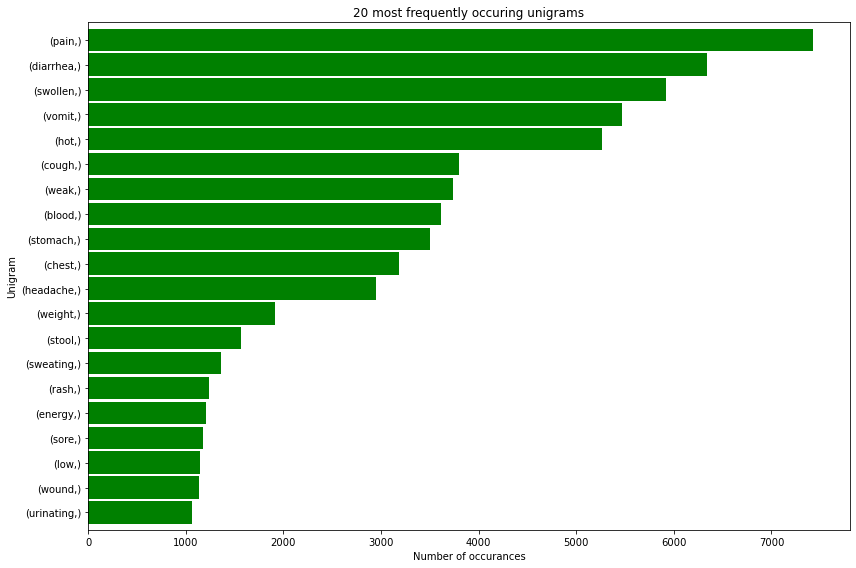

In [66]:
fig = plt.figure(figsize = (12, 8))
top_20_unigrams.sort_values().plot.barh(color='green', width=.9)
plt.title('20 most frequently occuring unigrams')
plt.ylabel('Unigram')
plt.xlabel('Number of occurances')
fig.tight_layout()
fig.savefig("unigrams.png", dpi = 1600)
fig.savefig("unigrams.pdf", dpi = 1600)
plt.show()

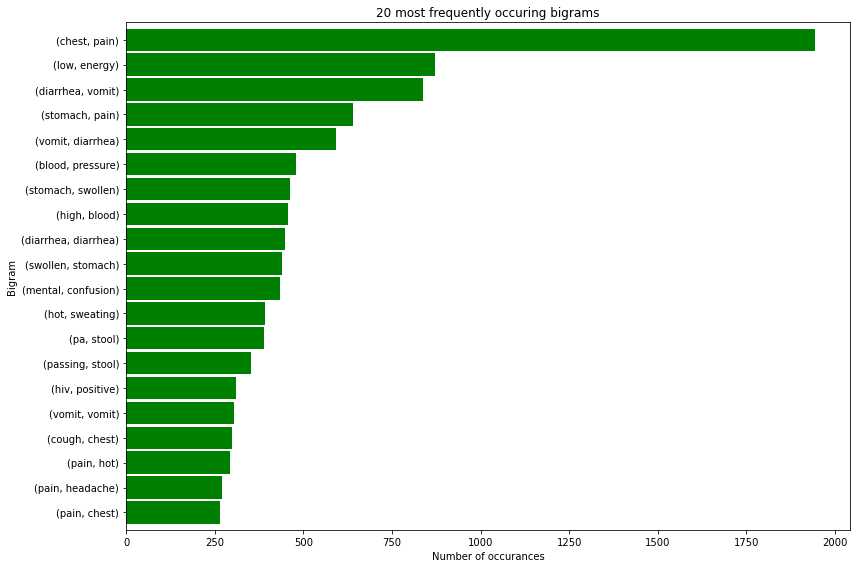

In [67]:
fig = plt.figure(figsize = (12, 8))
top_20_bigrams.sort_values().plot.barh(color='green', width=.9)
plt.title('20 most frequently occuring bigrams')
plt.ylabel('Bigram')
plt.xlabel('Number of occurances')
fig.tight_layout()
fig.savefig("bigrams.png", dpi = 1600)
fig.savefig("bigrams.pdf", dpi = 1600)
plt.show()

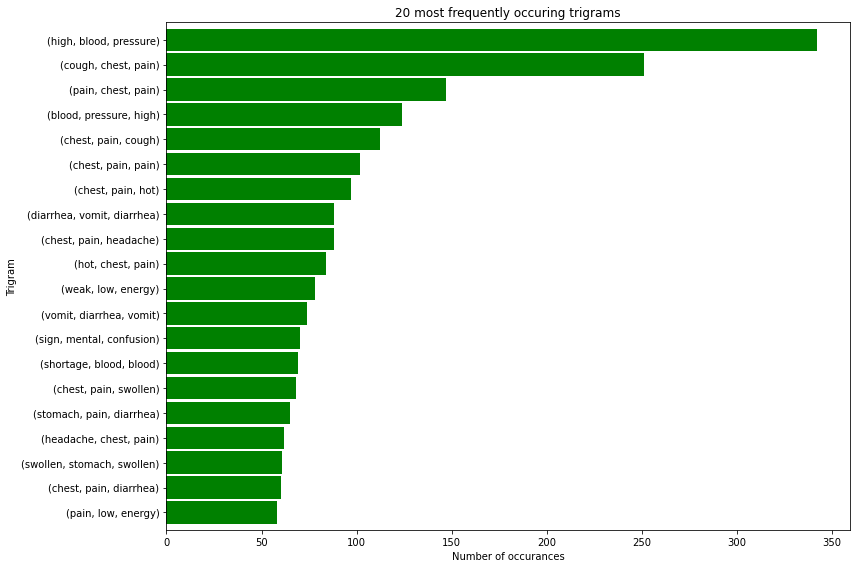

In [68]:
fig = plt.figure(figsize = (12, 8))
top_20_trigrams.sort_values().plot.barh(color='green', width=.9)
plt.title('20 most frequently occuring trigrams')
plt.ylabel('Trigram')
plt.xlabel('Number of occurances')
fig.tight_layout()
fig.savefig("trigrams.png", dpi = 1600)
fig.savefig("trigrams.pdf", dpi = 1600)
plt.show()

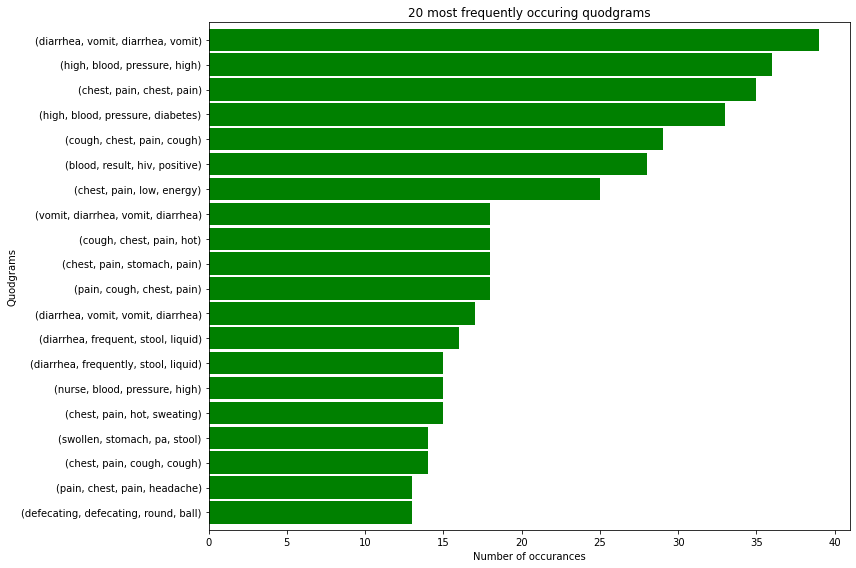

In [69]:
fig = plt.figure(figsize = (12, 8))
top_20_quodgrams.sort_values().plot.barh(color='green', width=.9)
plt.title('20 most frequently occuring quodgrams')
plt.ylabel('Quodgrams')
plt.xlabel('Number of occurances')
fig.tight_layout()
fig.savefig("quodgrams.png", dpi = 1600)
fig.savefig("quodgrams.pdf", dpi = 1600)
plt.show()

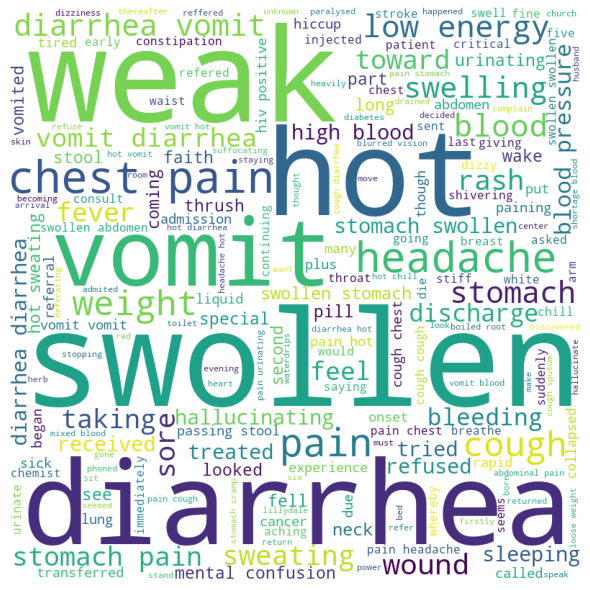

In [70]:
# Create and generate a word cloud image
comment_words = ''
stopwords = set(stopwords)
# iterate through the csv file
for val in dfA.disease_description:  
    # typecaste each val to string
    val = str(val)
    # split the value
    tokens = val.split() 
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()    
    comment_words += " ".join(tokens)+" "
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                max_words = 300,
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
# plot the WordCloud image                       
fig = plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
fig.savefig("wordcloud_figure.png", dpi = 1600)
fig.savefig("wordcloud_figure.pdf", dpi = 1600)
plt.show() 

In [71]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]


data = dfA['disease_description'].values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

data_words[:1][0][:30]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\a0056407\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['cough',
 'chest',
 'pain',
 'tiredness',
 'blood',
 'vision',
 'stomach',
 'pain',
 'diarrhea',
 'vomit',
 'worm',
 'diarrhea',
 'sneezed',
 'worm',
 'hot',
 'chest',
 'throat',
 'wound',
 'lip',
 'rash',
 'chapping',
 'blood',
 'lip',
 'pain',
 'cough',
 'headache',
 'hiccup',
 'skip',
 'defecating',
 'defecate']

In [72]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
corpus[:1][0][:30]

[(0, 2),
 (1, 1),
 (2, 2),
 (3, 2),
 (4, 1),
 (5, 1),
 (6, 2),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 2),
 (11, 3),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 1),
 (21, 1),
 (22, 3),
 (23, 1),
 (24, 1)]

In [73]:
from pprint import pprint

# number of topics
num_topics = 30

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(25,
  '0.038*"diarrhea" + 0.033*"hot" + 0.028*"vomit" + 0.022*"pain" + '
  '0.020*"swollen" + 0.016*"blood" + 0.016*"stomach" + 0.015*"weak" + '
  '0.014*"headache" + 0.012*"stool"'),
 (18,
  '0.050*"diarrhea" + 0.036*"pain" + 0.029*"vomit" + 0.021*"cough" + '
  '0.021*"weak" + 0.016*"swollen" + 0.013*"blood" + 0.012*"hot" + '
  '0.012*"stomach" + 0.010*"weight"'),
 (22,
  '0.058*"vomit" + 0.039*"diarrhea" + 0.024*"hot" + 0.022*"pain" + '
  '0.012*"weak" + 0.011*"headache" + 0.010*"stomach" + 0.009*"chest" + '
  '0.008*"swollen" + 0.008*"energy"'),
 (19,
  '0.070*"pain" + 0.029*"swollen" + 0.025*"chest" + 0.020*"vomit" + '
  '0.015*"headache" + 0.012*"weak" + 0.012*"hot" + 0.011*"cough" + '
  '0.011*"blood" + 0.010*"diarrhea"'),
 (11,
  '0.017*"hot" + 0.017*"cough" + 0.016*"stomach" + 0.015*"vomit" + '
  '0.013*"pain" + 0.012*"swollen" + 0.008*"cry" + 0.008*"chest" + '
  '0.007*"treated" + 0.007*"diarrhea"'),
 (28,
  '0.020*"diarrhea" + 0.019*"stomach" + 0.017*"swollen" + 0.014*"hot"

In [74]:
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
5     -0.032896  0.000662       1        1  8.284163
1     -0.054518  0.023667       2        1  7.292632
26    -0.042958  0.000200       3        1  5.849238
20    -0.033536 -0.025346       4        1  5.539153
7     -0.036330  0.000392       5        1  4.702621
18    -0.046949  0.006231       6        1  4.623915
25    -0.037094 -0.003339       7        1  4.086845
4     -0.033640  0.011044       8        1  4.035520
19    -0.017643 -0.001381       9        1  4.010926
10    -0.024066 -0.017258      10        1  3.808171
29    -0.005359  0.008685      11        1  3.635233
16    -0.022846  0.012335      12        1  3.402171
24    -0.005159  0.007716      13        1  3.284461
0      0.000899 -0.026612      14        1  3.279053
6      0.000727 -0.044491      15        1  3.260115
13     0.009690 -0.037171      16        1  3.159620
9     -0.002193  0.004276      17        1  3.138214
22    -0.011335  0.017204      18        1  3.008285
23    -0.023700 -0.014771      19        1  2.863303
11     0.040658  0.021292      20        1  2.378833
15    -0.023825  0.021985      21        1  2.275275
27     0.012817 -0.025311      22        1  2.020825
21     0.006871  0.022319      23        1  1.793810
8      0.060473  0.011473      24        1  1.782439
17     0.026717 -0.042812      25        1  1.771216
14     0.007941 -0.007374      26        1  1.686009
3      0.075048 -0.069810      27        1  1.480922
2      0.134671  0.010178      28        1  1.241499
28     0.037412  0.009953      29        1  1.176977
12     0.040122  0.126068      30        1  1.128554, topic_info=                  Term         Freq        Total Category  logprob  loglift
6             diarrhea  6046.000000  6046.000000  Default  30.0000  30.0000
0                blood  3487.000000  3487.000000  Default  29.0000  29.0000
21               vomit  5170.000000  5170.000000  Default  28.0000  28.0000
9                  hot  4929.000000  4929.000000  Default  27.0000  27.0000
35             swollen  5617.000000  5617.000000  Default  26.0000  26.0000
3                cough  3714.000000  3714.000000  Default  25.0000  25.0000
11                pain  7162.000000  7162.000000  Default  24.0000  24.0000
12                rash  1155.000000  1155.000000  Default  23.0000  23.0000
36                weak  3613.000000  3613.000000  Default  22.0000  22.0000
16             stomach  3297.000000  3297.000000  Default  21.0000  21.0000
2                chest  3160.000000  3160.000000  Default  20.0000  20.0000
210                car   493.000000   493.000000  Default  19.0000  19.0000
7             headache  2868.000000  2868.000000  Default  18.0000  18.0000
25            bleeding   987.000000   987.000000  Default  17.0000  17.0000
672               high   758.000000   758.000000  Default  16.0000  16.0000
30              weight  1867.000000  1867.000000  Default  15.0000  15.0000
373                cry   552.000000   552.000000  Default  14.0000  14.0000
23               wound  1132.000000  1132.000000  Default  13.0000  13.0000
286                low  1109.000000  1109.000000  Default  12.0000  12.0000
678           pressure   487.000000   487.000000  Default  11.0000  11.0000
27              breast   571.000000   571.000000  Default  10.0000  10.0000
103          urinating  1015.000000  1015.000000  Default   9.0000   9.0000
293               sore  1137.000000  1137.000000  Default   8.0000   8.0000
17               stool  1462.000000  1462.000000  Default   7.0000   7.0000
786                hiv   730.000000   730.000000  Default   6.0000   6.0000
231               hour   770.000000   770.000000  Default   5.0000   5.0000
68                feel   789.000000   789.000000  Default   4.0000   4.0000
524          discharge   658.000000   658.000000  Default   3.0000   3.0000
146             coming   755.000000   755.000000  Default

In [75]:
import spacy
#import pyLDAvis.gensim_models
#pyLDAvis.enable_notebook()# Visualise inside a notebook
import en_core_web_md
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel

# Our spaCy model:
nlp = en_core_web_md.load()

# Tags I want to remove from the text
removal = ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']
tokens = []

for summary in nlp.pipe(dfA['disease_description']):
   proj_tok = [token.lemma_.lower() for token in summary if token.pos_ not in removal and not token.is_stop and token.is_alpha]
   tokens.append(proj_tok)

# Add tokens to new column
dfA['tokens'] = tokens
#dfA['tokens']

# Create dictionary
# I will apply the Dictionary Object from Gensim, which maps each word to their unique ID:
dictionary = Dictionary(dfA['tokens'])
print(dictionary.token2id)

{'blood': 0, 'chap': 1, 'chest': 2, 'cough': 3, 'defecate': 4, 'diarrhea': 5, 'headache': 6, 'hiccup': 7, 'hot': 8, 'lip': 9, 'pain': 10, 'rash': 11, 'ring': 12, 'skip': 13, 'sneeze': 14, 'stomach': 15, 'stool': 16, 'throat': 17, 'tiredness': 18, 'vision': 19, 'vomit': 20, 'worm': 21, 'wound': 22, 'yellowish': 23, 'bleed': 24, 'blister': 25, 'breast': 26, 'nasal': 27, 'sweat': 28, 'weight': 29, 'pass': 30, 'penis': 31, 'urine': 32, 'stiff': 33, 'swollen': 34, 'weak': 35, 'organ': 36, 'ache': 37, 'asthma': 38, 'ball': 39, 'defeacate': 40, 'discover': 41, 'energy': 42, 'eye': 43, 'fatique': 44, 'foot': 45, 'look': 46, 'refer': 47, 'round': 48, 'swell': 49, 'swelling': 50, 'thinking': 51, 'tindzhaka': 52, 'transfer': 53, 'whith': 54, 'belt': 55, 'bowel': 56, 'contain': 57, 'cramp': 58, 'distance': 59, 'drain': 60, 'enema': 61, 'faith': 62, 'feel': 63, 'green': 64, 'healer': 65, 'idea': 66, 'little': 67, 'lung': 68, 'movement': 69, 'referal': 70, 'shw': 71, 'substance': 72, 'urinate': 73, 

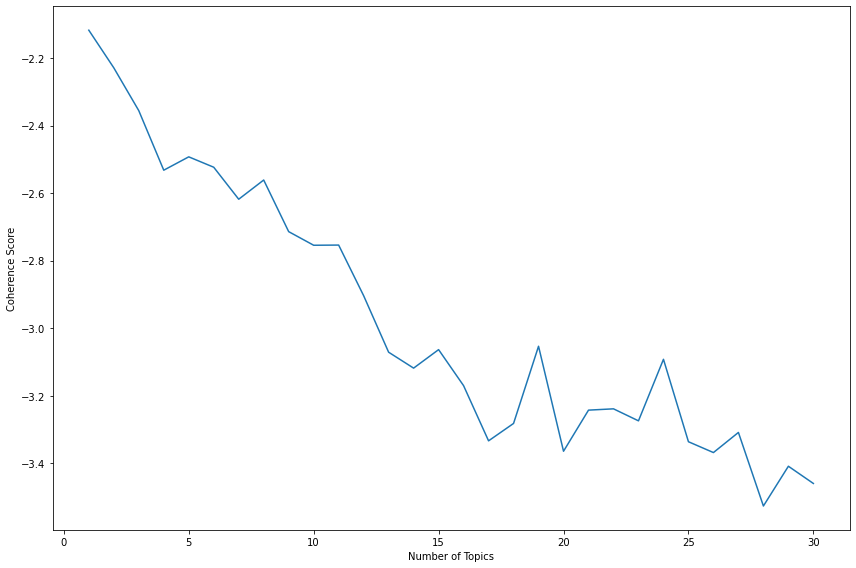

In [76]:
# Filter dictionary
dictionary.filter_extremes(no_below = 5, no_above = 0.5, keep_n = 1000)

# Create corpus
corpus = [dictionary.doc2bow(doc) for doc in dfA['tokens']]

# LDA model building
lda_model = LdaMulticore(corpus = corpus, id2word = dictionary, iterations = 100, num_topics = 30, workers = 4, passes = 100)

# Coherence score using C_umass:
topics = []
score = []
fig = plt.figure(figsize = (12, 8))  
for i in range(1, 31, 1):
   lda_model = LdaMulticore(corpus = corpus, id2word = dictionary, iterations = 50, num_topics = i, workers = 4, passes = 10, random_state = 100)
   cm = CoherenceModel(model = lda_model, corpus = corpus, dictionary = dictionary, coherence = 'u_mass')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
fig.tight_layout()
fig.savefig("topics_measures.png", dpi = 1600)
fig.savefig("topics_measures.pdf", dpi = 1600)
plt.show()

In [77]:
# Optimal model
lda_model = LdaMulticore(corpus = corpus, id2word = dictionary, iterations = 500, num_topics = 30, workers = 4, passes = 100)

# Print topics
lda_model.print_topics(-1)



[(0,
  '0.084*"swell" + 0.078*"hot" + 0.066*"pain" + 0.063*"weight" + 0.045*"chill" + 0.041*"healer" + 0.031*"herb" + 0.030*"loose" + 0.029*"ache" + 0.024*"weak"'),
 (1,
  '0.159*"hot" + 0.126*"cry" + 0.107*"hour" + 0.057*"breast" + 0.057*"refuse" + 0.032*"feed" + 0.032*"worsen" + 0.028*"weak" + 0.024*"care" + 0.023*"thrush"'),
 (2,
  '0.053*"special" + 0.038*"year" + 0.030*"transfer" + 0.024*"die" + 0.021*"garankuwa" + 0.019*"receive" + 0.019*"fail" + 0.019*"spend" + 0.018*"unknown" + 0.017*"pill"'),
 (3,
  '0.109*"call" + 0.075*"say" + 0.073*"panado" + 0.046*"syrup" + 0.037*"people" + 0.032*"hear" + 0.030*"phone" + 0.030*"soft" + 0.028*"see" + 0.025*"porridge"'),
 (4,
  '0.311*"rash" + 0.080*"root" + 0.061*"boil" + 0.057*"itchy" + 0.027*"weight" + 0.026*"hair" + 0.023*"look" + 0.022*"lip" + 0.021*"reddish" + 0.019*"liquid"'),
 (5,
  '0.249*"blood" + 0.075*"weak" + 0.067*"vomit" + 0.064*"start" + 0.041*"shortage" + 0.037*"inject" + 0.032*"lung" + 0.024*"continue" + 0.021*"come" + 0.02

In [38]:
# Where does a text belong to
print(lda_model[corpus][0])
print(dfA['disease_description'][0])

dfA['topic'] = [sorted(lda_model[corpus][text])[0][0] for text in range(len(dfA['disease_description']))]
print(dfA['topic'].value_counts())

[(6, 0.16136855), (8, 0.034268167), (11, 0.16765366), (13, 0.0833086), (15, 0.037746888), (17, 0.09781643), (18, 0.03563328), (23, 0.030771503), (26, 0.06174883), (27, 0.20933902), (29, 0.061716627)]
cough chest pain tiredness blood vision stomach pain diarrhea vomit worm diarrhea sneezed worm hot chest throat wound lip rash chapping blood lip pain cough headache hiccup skip defecating defecate stool yellowish ring worm
0     2616
1     1784
3     1437
2     1312
4      916
7      777
8      733
6      713
11     639
5      638
10     508
9      463
13     439
14     186
12     134
25     133
16     118
24      95
18      84
15      56
28      42
19      42
17      41
21      36
20      30
27      27
26      26
22      20
23      18
29      16
Name: topic, dtype: int64


EXPERIMENTS

In [39]:
topic_data =  pyLDAvis.gensim.prepare(ldamodel2, doc_term_matrix, dictionary, mds = 'pcoa')
pyLDAvis.display(topic_data)

AttributeError: module 'pyLDAvis' has no attribute 'gensim'

In [ ]:
all_topics = {}
num_terms = 10 # Adjust number of words to represent each topic
lambd = 0.6 # Adjust this accordingly based on tuning above
for i in range(1,32): #Adjust this to reflect number of topics chosen for final LDA model
    topic = topic_data.topic_info[topic_data.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values

In [ ]:
pd.DataFrame(all_topics).T